# Basic characterizations of LA Q3
### using Experiment and Analysis classes

In [1]:
from qm.qua import *
from qm import QuantumMachinesManager, SimulationConfig, LoopbackInterface, generate_qua_script
from qm.octave import *
from configuration import *
from scipy import signal
from qualang_tools.bakery import baking
from qm.octave import QmOctaveConfig
from quam import QuAM

from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
#from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber
import xarray as xr

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 0 # for LA Q3
TLS_index = 0 # for TLS of interest
dc_flux_index = 6 # for dc line

2024-06-28 11:40:19,425 - qm - INFO     - Starting session: e9b2493e-a135-4b20-9a3d-881db4dc7eb8


In [2]:
Analysis = AnalysisHandle("quam_state_q6.json")
machine = Analysis.get_machine()
Experiment = ExperimentHandle(machine)

In [3]:
# Set voltage of flux line to 0 V
for i in np.arange(7): 
    machine.dc_flux[i].dc_voltage = 0 + 0E6
machine = Analysis.set_machine(machine)

In [4]:
# initialize Labber-controlled hardware
# get values from QDAC first
#machine = Experiment.set_Labber.get_value_from_QDAC(machine)
# set all Labber settings
machine = Experiment.set_Labber.set_Labber(machine, qubit_index)
# set octave to external clock
#Experiment.set_octave.set_clock(machine)

In [19]:
# set to qubit
machine.octaves[0].LO_sources[1].LO_frequency = machine.qubits[qubit_index].f_01 + 50e6
machine = Analysis.set_machine(machine)

In [6]:
machine.octaves[0].LO_sources[1].gain = 0
machine = Analysis.set_machine(machine)

In [22]:
# octave calibration
machine = Experiment.set_octave.calibration(machine, qubit_index)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q6 for (LO, IF) = (5.464 GHz, -50.000 MHz)
------------------------------------- Calibrates r6 for (LO, IF) = (6.071 GHz, -50.000 MHz)
------------------------------------- Octave calibration finished.


# Qubit Readout

## Time of Flight

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 41.46s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0628\2024-06-28_q6_time_of_flight
DC offset to add to I: 0.000374 V
DC offset to add to Q: 0.000587 V
TOF to add: 0.0 ns


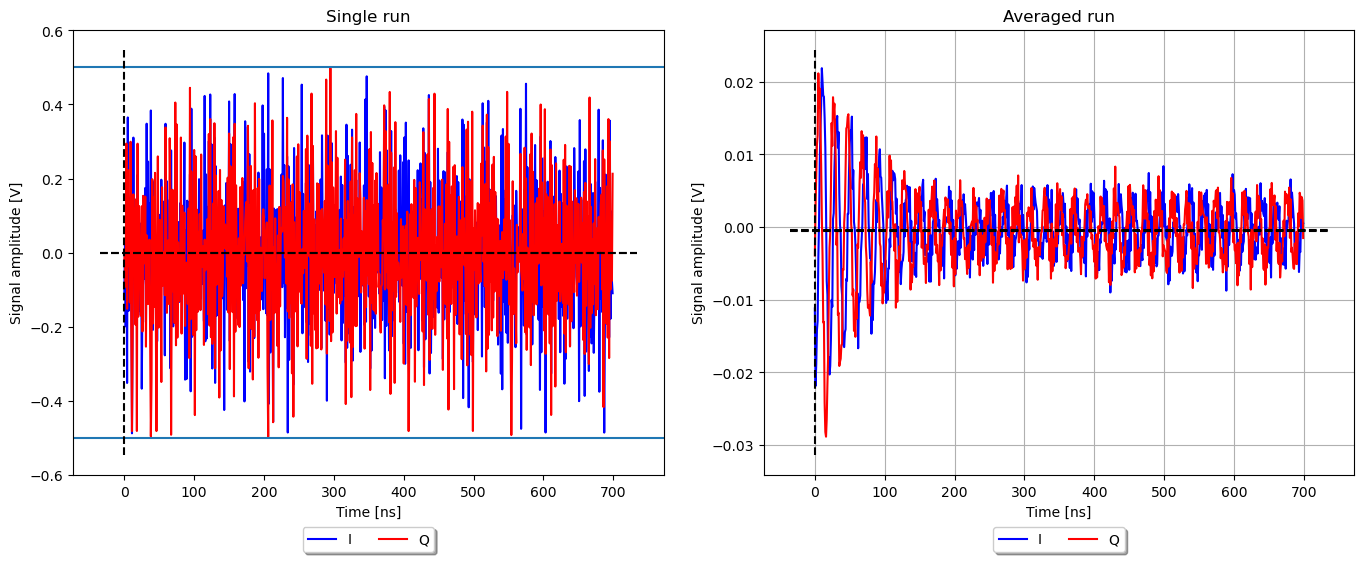

In [8]:
# time_of_flight
# experiment
%matplotlib qt
machine, expt_dataset = Experiment.exp1D.RR.time_of_flight(machine,qubit_index, n_avg = 10E3, cd_time = 10E3, to_simulate = False, simulation_len = 1000)
# plot
%matplotlib inline
dc_offset_i, dc_offset_q, delay = Analysis.exp1D.time_of_flight(expt_dataset)

In [9]:
# update the offset
machine.global_parameters.downconversion_offset_I[0] += dc_offset_i
machine.global_parameters.downconversion_offset_Q[0] += dc_offset_q
machine.resonators[qubit_index].downconversion_offset_I = machine.global_parameters.downconversion_offset_I[0]
machine.resonators[qubit_index].downconversion_offset_Q = machine.global_parameters.downconversion_offset_Q[0]
#machine.global_parameters.time_of_flight = 304-0
machine = Analysis.set_machine(machine)

In [ ]:
# If we need to reduce the RO gain if we think we are saturating digitizers
machine.global_parameters.downconversion_gain[0] = -1
machine.resonators[qubit_index].downconversion_gain = -1
machine = Analysis.set_machine(machine)

## Resonator spectroscopy

### 1D resonator spectroscopy

In [10]:
machine.resonators[qubit_index].readout_pulse_amp = 0.4

In [25]:
%matplotlib qt
res_freq_sweep = machine.resonators[qubit_index].f_readout + np.arange(-5E6,5E6 + 1.0,0.05E6)
machine, expt_dataset = Experiment.exp1D.RR.rr_freq(machine, res_freq_sweep, qubit_index, n_avg = 1E3, cd_time = 10E3, live_plot = True,
                                                    readout_state = 'g', to_simulate = False, data_process_method = 'Amplitude')
# Readout in excited state
# machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
#                           n_avg = 1E3, cd_time = 5E3, readout_state = 'e', simulate_flag = False, simulation_len = 1000)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 2.37s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0628\2024-06-28_q6_res_spec_3
Execution stopped by user!


resonator frequency: 6021.550 MHz


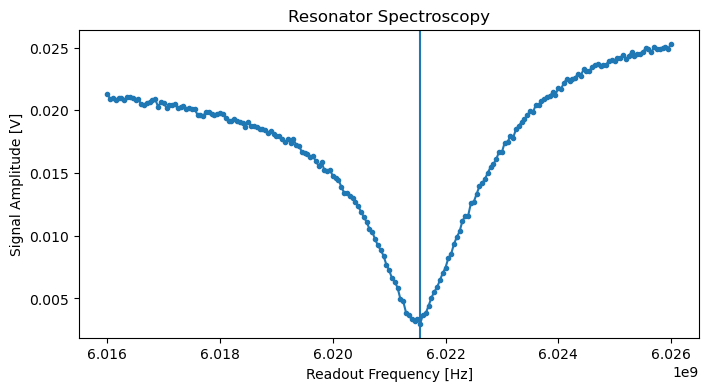

In [26]:
# find the minimal
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(expt_dataset)
machine.resonators[qubit_index].f_readout = res_freq + 0E6

In [27]:
machine.octaves[0].LO_sources[0].LO_frequency = machine.resonators[qubit_index].f_readout + 50E6
machine = Experiment.set_octave.calibration(machine, qubit_index)
machine = Analysis.set_machine(machine)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q6 for (LO, IF) = (5.464 GHz, -50.000 MHz)
------------------------------------- Calibrates r6 for (LO, IF) = (6.072 GHz, -50.000 MHz)
------------------------------------- Octave calibration finished.


### 2D resonator spectroscopy

In [14]:
res_freq_sweep = np.arange(6.01E9,6.024E9 + 1.0,0.1E6)
dc_flux_sweep = np.arange(-9,9.001,0.1)
%matplotlib qt
machine, expt_dataset = Experiment.exp2D.RR.rr_vs_dc_flux(machine, res_freq_sweep, dc_flux_sweep, qubit_index,
                                                          n_avg = 1E3, cd_time = 10E3, live_plot = True)

Progress: [##################################################] 100.0% (n=181/181) --> elapsed time: 439.54s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0628\2024-06-28_q6_res_spec2D


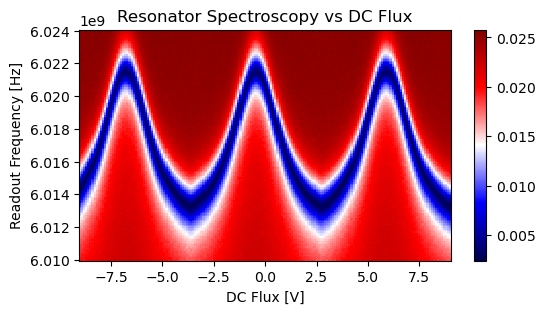

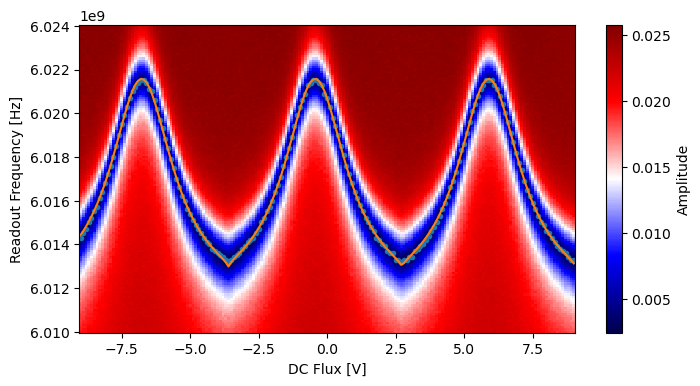

Execution stopped by user!


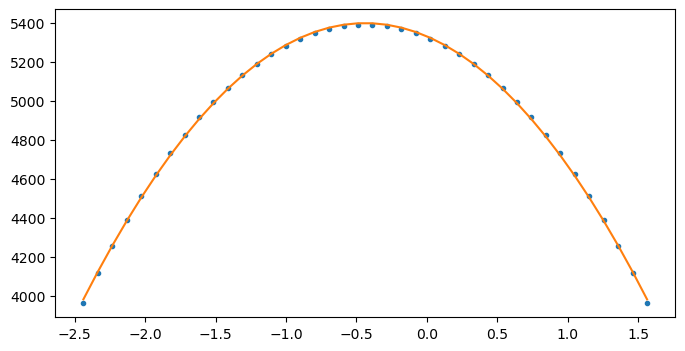

In [15]:
%matplotlib inline 
ham_param = Analysis.exp2D.rr_vs_dc_flux(expt_dataset, to_plot = True, init_guess = [6021, 170, 25E3, 0.05, 0.4, 80])
# The last fitted params cause the guess above takes a long time: [6011, 120,31000, 0.08, 0.1, 76]
poly_param = Analysis.exp2D.qubit_vs_dc_flux_guess(ham_param = ham_param, to_plot = True)

In [16]:
# save the fitting parameters
machine.resonators[qubit_index].tuning_curve = ham_param
machine.qubits[qubit_index].DC_tuning_curve = poly_param
machine = Analysis.set_machine(machine)

In [17]:
# save the sweep spot flux according to fitted parameter
machine.dc_flux[dc_flux_index].max_frequency_point = Analysis.get_sweept_spot(poly_param)
machine = Analysis.set_machine(machine)

if 2D res spectroscopy is just to test the experiment, and I want to go back to sweet spot

In [23]:
machine = Analysis.update_machine_res_frequency_sweet_spot(machine, qubit_index, dc_flux_index) 
machine.octaves[0].LO_sources[0].LO_frequency = machine.resonators[qubit_index].f_readout + 50e6
machine.dc_flux[dc_flux_index].dc_voltage = machine.dc_flux[dc_flux_index].max_frequency_point
machine = Experiment.set_Labber.set_Labber(machine, qubit_index)
machine = Analysis.set_machine(machine)
# octave calibration
machine = Experiment.set_octave.calibration(machine, qubit_index)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q6 for (LO, IF) = (5.464 GHz, -50.000 MHz)
------------------------------------- Calibrates r6 for (LO, IF) = (6.071 GHz, -50.000 MHz)
------------------------------------- Octave calibration finished.


# Qubit Sweet Spot Calibrations

## 1D qubit spectroscopy @ sweep spot

In [36]:
if True: # for the DC flux
    qubit_freq_est = np.polyval(machine.qubits[qubit_index].DC_tuning_curve,machine.dc_flux[dc_flux_index].max_frequency_point) * 1E6 # in Hz
else: # for the fast flux
    qubit_freq_est = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,0.0) * 1E6 # in Hz

qubit_freq_sweep = int(qubit_freq_est) + np.arange(-10E6, 0E6 + 1, 0.2E6)
    
%matplotlib qt
machine, expt_dataset = Experiment.exp1D.Rabi.qubit_freq(machine, qubit_freq_sweep, qubit_index, pi_amp_rel = 1.0, live_plot = True,
                                                         ff_amp = 0.0, n_avg = 2E3, cd_time = 30E3, to_simulate = False, data_process_method = 'Amplitude')

Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 3.56s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0628\2024-06-28_q6_spec_6
Execution stopped by user!


peak frequency:  5395.6 [MHz]


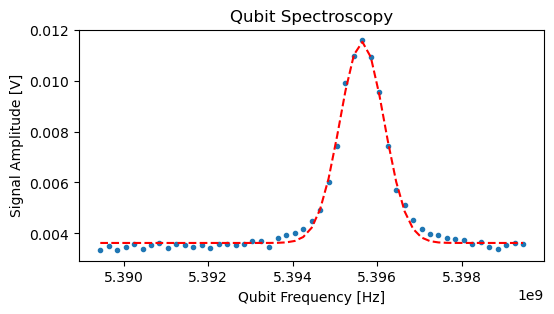

In [38]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(expt_dataset, method="Gaussian", data_process_method = 'Amplitude')
machine.qubits[qubit_index].f_01 = qubit_freq + 0E6

In [39]:
machine.octaves[0].LO_sources[1].LO_frequency = machine.qubits[qubit_index].f_01 + 50e6
machine = Experiment.set_octave.calibration(machine, qubit_index)
machine = Analysis.set_machine(machine)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q6 for (LO, IF) = (5.446 GHz, -50.000 MHz)
2024-06-28 12:13:06,418 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-06-28 12:13:06,549 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-06-28 12:13:06,579 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-06-28 12:13:06,622 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-06-28 12:13:06,637 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-06-28 12:13:06,656 - qm - ERROR    - Runtime errors were

## Rabi

### Time Rabi

In [55]:
%matplotlib qt
rabi_duration_sweep = np.arange(16, 210 + 0.1, 4)  # in ns
machine, expt_dataset = Experiment.exp1D.Rabi.rabi_length(machine, rabi_duration_sweep, qubit_index, pi_amp_rel = 1.0, live_plot = True, 
                                                          n_avg = 1E4, cd_time = 25E3, to_simulate = False, data_process_method = 'I')

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 12.90s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0628\2024-06-28_q6_time_rabi_3


rabi_pi_pulse: 99.6 [ns]
pi period: 97.98 [ns]


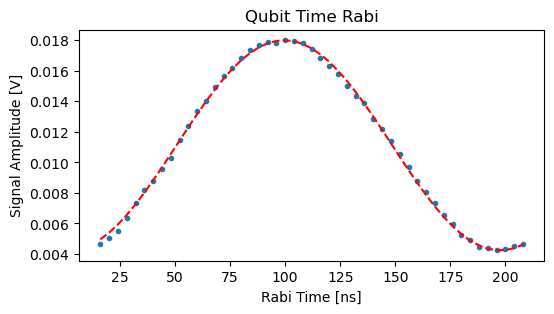

In [57]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(expt_dataset, method = "Sine", to_plot = True, data_process_method = 'Amplitude')

In [40]:
machine.qubits[qubit_index].pi_length = 100
# machine.qubits[qubit_index].pi_amp *= 10
machine = Analysis.set_machine(machine)

### Power Rabi

In [52]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.12, 1.5, 0.02) 
machine, expt_dataset = Experiment.exp1D.Rabi.rabi_amp(machine, rabi_amp_sweep_rel, qubit_index, ff_amp = 0.0, live_plot = True,
                                       n_avg = 1E4, cd_time = 30E3, data_process_method = 'Amplitude')

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 21.66s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0628\2024-06-28_q6_power_rabi_4


rabi_pi_amp: 0.031 [V]
pi period: 0.029 [V]


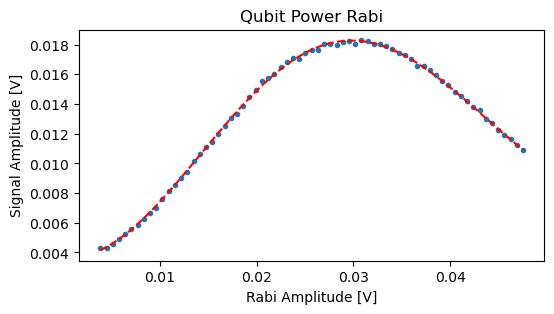

In [54]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(expt_dataset, method = "Decay", data_process_method = 'Amplitude')
machine.qubits[qubit_index].pi_amp = pi_pulse_amp
machine = Analysis.set_machine(machine)

## Single-Shot Readout

### Find frequency between g, e

In [59]:
%matplotlib qt
res_freq_sweep = machine.resonators[qubit_index].f_readout + np.arange(-8E6,5E6 + 1.0,0.05E6)
machine, expt_dataset = Experiment.exp1D.RR.rr_freq_ge(machine, res_freq_sweep, qubit_index, n_avg = 2E3, cd_time = 20E3,
                                                    to_simulate = False, simulation_len = 1E3, live_plot = True, data_process_method = 'Phase')

Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 21.98s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0628\2024-06-28_q6_res_spec_ge_2


resonator frequency: 6019.250 MHz


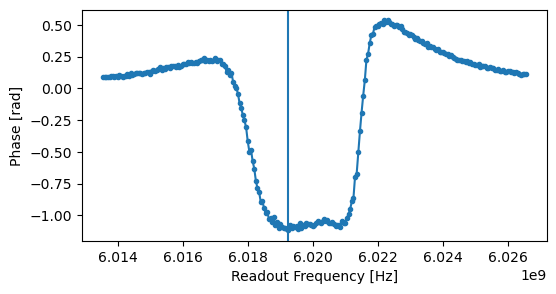

In [61]:
%matplotlib inline
res_freq_phase = Analysis.exp1D.rr_freq_ge(expt_dataset)

In [62]:
# doesn't have to update. Use res_freq_phase
machine.resonators[qubit_index].f_readout = res_freq_phase + 0E6
machine.octaves[0].LO_sources[0].LO_frequency = machine.resonators[qubit_index].f_readout + 50E6
machine = Experiment.set_octave.calibration(machine, qubit_index)
machine = Analysis.set_machine(machine)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q6 for (LO, IF) = (5.446 GHz, -50.000 MHz)
------------------------------------- Calibrates r6 for (LO, IF) = (6.069 GHz, -50.000 MHz)
------------------------------------- Octave calibration finished.


### IQ blobs

In [82]:
%matplotlib inline
machine, expt_dataset = Experiment.exp1D.RR.single_shot_IQ_blob(machine, qubit_index, n_avg = 30E3, cd_time = 25E3, final_plot = False)

----------saved to Z:\QM_Data_DF5\2024\06\Data_0628\2024-06-28_q6_single_shot_IQ_7--> elapsed time: 1.66s



			Fidelity Matrix:
			-----------------
			| 0.960 | 0.040 |
			----------------
			| 0.171 | 0.829 |
			-----------------
			IQ plane rotated by: 0.7°
			Threshold: -3.007e-03
			Fidelity: 89.5%
			


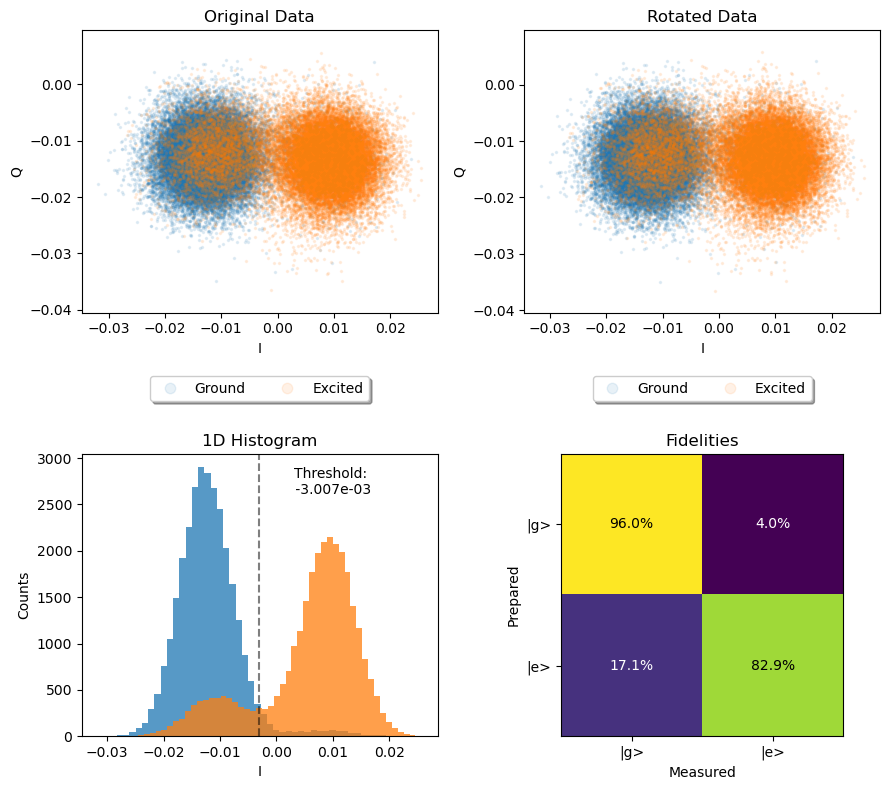

In [83]:
%matplotlib inline
angle, threshold, fidelity, gg, ge, eg, ee = Analysis.exp1D.two_state_discriminator(expt_dataset)

In [65]:
# set the rotation angle
machine.resonators[qubit_index].rotation_angle -= angle # note this is the change value not the absolute value!
machine.resonators[qubit_index].ge_threshold = threshold
machine = Analysis.set_machine(machine)

In [81]:
machine.resonators[qubit_index].readout_pulse_length = 600
machine.resonators[qubit_index].readout_pulse_amp = 0.42
machine = Analysis.set_machine(machine)

### Readout freq optimization

In [88]:
res_freq_sweep = machine.resonators[qubit_index].f_readout + np.arange(-3E6, 3E6 + 1, 0.05E6)

%matplotlib qt
machine, expt_dataset = Experiment.exp1D.RR.single_shot_freq_optimization(machine, res_freq_sweep, qubit_index, n_avg = 5E4, cd_time = 25E3, 
                                                           final_plot = True, live_plot = True)

Progress: [##################################################] 100.0% (n=50000/50000.0) --> elapsed time: 310.41s
Progress: [##################################################] 100.0% (n=50000/50000.0) --> elapsed time: 311.04s
----------saved to Z:\QM_Data_DF5\2024\05\Data_0528\2024-05-28_q6_single_shot_freq_2
The optimal readout frequency is 6020350000.0 Hz (SNR=3.616708311261063)


peak frequency:  6020.2 [MHz]


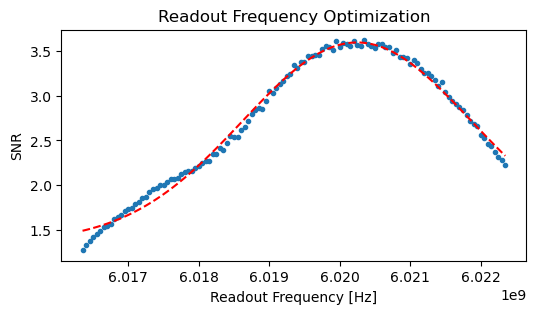

In [90]:
%matplotlib inline
res_freq = Analysis.exp1D.peak_fit(expt_dataset,method="Gaussian", data_process_method = 'SNR')

In [91]:
res_freq

6020245613

In [92]:
machine.resonators[qubit_index].f_readout = res_freq + 0E6
machine.octaves[0].LO_sources[0].LO_frequency = machine.resonators[qubit_index].f_readout + 50E6
machine = Analysis.set_machine(machine)
# octave calibration
machine = Experiment.set_octave.calibration(machine, qubit_index)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q6 for (LO, IF) = (5.465 GHz, -50.000 MHz)
------------------------------------- Calibrates r6 for (LO, IF) = (6.070 GHz, -50.000 MHz)
------------------------------------- Octave calibration finished.


### Readout pulse amp and duration (by qubit relaxation during readout)

In [89]:
%matplotlib qt
res_duration_sweep_abs = np.arange(300, 2000 + 1, 20)
res_amp_sweep_abs = np.arange(0.15,0.45,0.001)
machine, expt_dataset = Experiment.exp2D.RR.rr_pulse_optimize(machine, res_duration_sweep_abs, res_amp_sweep_abs, qubit_index, n_avg=1E3, 
                                                              cd_time=25E3, live_plot = True, data_process_method = 'I')

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 738.93s
----------saved to Z:\QM_Data_DF5\2024\05\Data_0523\2024-05-23_q5_res_pulse_optimize


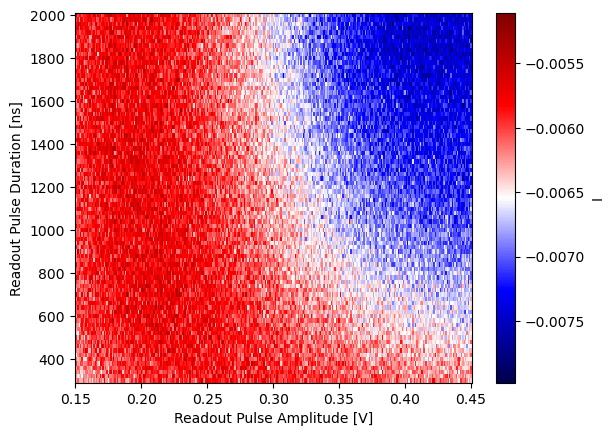

In [7]:
%matplotlib inline
data = xr.load_dataset(r"Z:\QM_Data_DF5\2024\05\Data_0523\2024-05-23_q5_res_pulse_optimize.nc")
data['I'].plot(x = list(data.coords.keys())[0], y = list(data.coords.keys())[1], cmap = "seismic")

In [17]:
machine.resonators[qubit_index].readout_pulse_amp = 0.3
machine.resonators[qubit_index].readout_pulse_length =1500
machine = Analysis.set_machine(machine)

### Readout duration optimization

In [101]:
division_length = 40
%matplotlib qt
machine, expt_dataset = Experiment.exp1D.RR.single_shot_duration_optimization(machine, division_length, qubit_index,
                                                                    readout_len = 2000, n_avg = 2E4, cd_time = 25E3)

Integration weights chunk-size length in ns: 40
The readout has been sliced in the following number of divisions 50
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 1.76s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 1.77s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 1.79s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 1.81s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 1.82s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 1.84s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 1.86s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed 

In [106]:
machine.resonators[qubit_index].readout_pulse_length = 600
machine = Analysis.set_machine(machine)

### Readout amp optimization

In [124]:
res_amp_sweep = np.arange(0.5,1.1 + 1E-4, 0.01)

%matplotlib qt
machine, expt_dataset = Experiment.exp1D.RR.single_shot_amp_optimization(machine, res_amp_sweep, qubit_index,
                              n_avg = 5E3, cd_time = 25E3, final_plot= True)

Progress: [##################################################] 100.0% (n=61/61) --> elapsed time: 15.35s
Progress: [##################################################] 100.0% (n=61/61) --> elapsed time: 15.38s
Progress: [##################################################] 100.0% (n=61/61) --> elapsed time: 15.40s
Progress: [##################################################] 100.0% (n=61/61) --> elapsed time: 15.42s
Progress: [##################################################] 100.0% (n=61/61) --> elapsed time: 15.45s
Progress: [##################################################] 100.0% (n=61/61) --> elapsed time: 15.48s
Progress: [##################################################] 100.0% (n=61/61) --> elapsed time: 15.50s
Progress: [##################################################] 100.0% (n=61/61) --> elapsed time: 15.53s
Progress: [##################################################] 100.0% (n=61/61) --> elapsed time: 15.55s
Progress: [############################################

peak voltage:  0.407 [V]


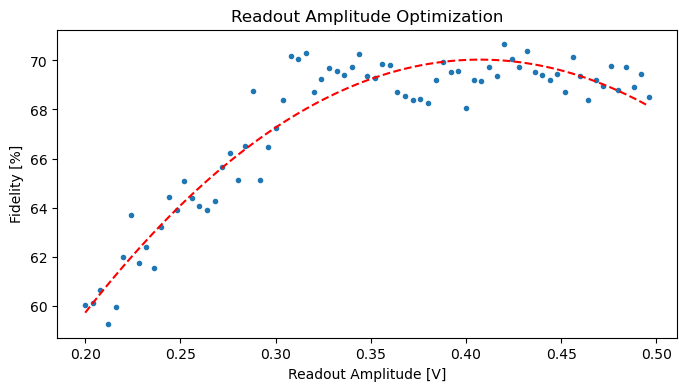

In [79]:
%matplotlib inline
readout_amp = Analysis.exp1D.peak_fit(expt_dataset, method="Gaussian", data_process_method = 'Fidelity')

In [24]:
machine.resonators[qubit_index].readout_pulse_amp = 0.404
machine = Analysis.set_machine(machine)

## Qubit T1

In [86]:
%matplotlib qt
tau_sweep_abs = np.arange(100,40E3+1,1E3)
machine, expt_dataset = Experiment.exp1D.T1.qubit_T1(machine, tau_sweep_abs, qubit_index, n_avg = 1E4, cd_time = 40E3, live_plot = True,
                                                               to_simulate = False, simulation_len = 15_000, data_process_method = 'I')

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 24.59s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0628\2024-06-28_q6_T1_2


Qubit T1: 5.7 [us]


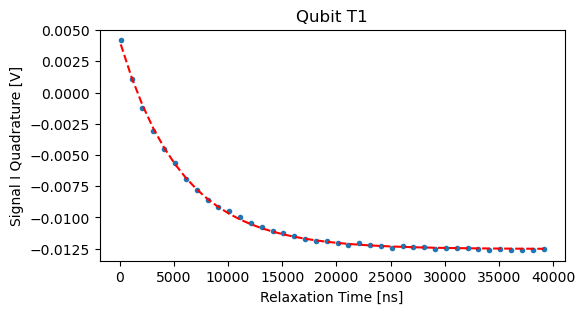

In [88]:
%matplotlib inline
qubit_T1 = Analysis.exp1D.T1(expt_dataset, data_process_method = 'I')
machine.qubits[qubit_index].T1 = qubit_T1
machine = Analysis.set_machine(machine)

## Qubit Ramsey

In [89]:
%matplotlib qt
ramsey_duration_sweep = np.arange(16, 3000 + 0.1, 20)  # in units of ns
machine, expt_dataset = Experiment.exp1D.Ramsey.ramsey(machine, ramsey_duration_sweep, qubit_index, detuning = 2E6, live_plot = True,
                                                       n_avg = 1E4, cd_time = 30E3, to_simulate = False, data_process_method = 'I')

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 48.57s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0628\2024-06-28_q6_ramsey
Execution stopped by user!


Qubit T2*:  425.3 [ns]
Exponent n =  1.5
Detuning =  2.1 [MHz]


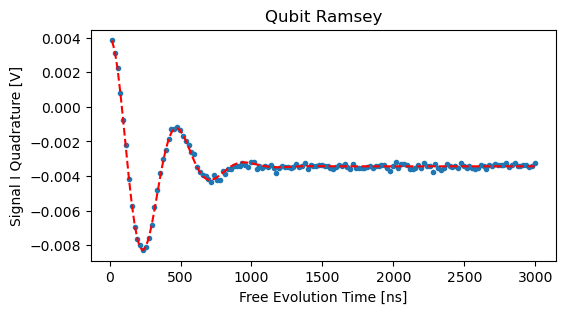

In [91]:
%matplotlib inline
q_T2star = Analysis.exp1D.ramsey(expt_dataset, data_process_method = 'I')
machine.qubits[qubit_index].T2 = q_T2star
machine = Analysis.set_machine(machine)

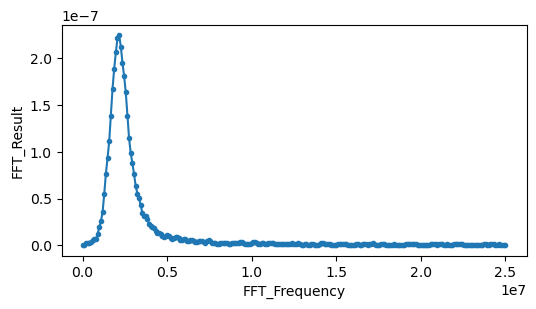

In [92]:
%matplotlib inline
fft_dataset = Analysis.exp1D.fft(expt_dataset, to_plot = True, data_process_method = 'I')

In [93]:
# Get the peak frequency
idx = fft_dataset['FFT_Result'].argmax().item()
max_freq = fft_dataset['FFT_Frequency'][idx].item()
max_freq

2156862.745098039

## ef transition

### ef frequency

In [ ]:
%matplotlib qt
ef_freq_sweep = machine.qubits[qubit_index].f_01 + np.arange(-190E6, -150E6 + 1, 0.5E6) 
machine, expt_dataset = Experiment.exp1D.Rabi.ef_freq(machine, ef_freq_sweep, qubit_index, pi_amp_rel_ef = 1.0, n_avg = 2E3, live_plot = True,
                                                      cd_time = 30E3, readout_state = 'g', to_simulate = False, data_process_method = 'I')

In [ ]:
%matplotlib inline
ef_freq = Analysis.exp1D.peak_fit(expt_dataset, method="Gaussian", data_process_method = 'I')

In [ ]:
machine.qubits[qubit_index].anharmonicity = machine.qubits[qubit_index].f_01 - ef_freq
machine = Analysis.set_machine(machine)

### ef transition time Rabi

In [ ]:
%matplotlib qt
rabi_duration_sweep = np.arange(16, 240 + 0.1, 4)  # in ns
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, expt_dataset = Experiment.exp1D.Rabi.ef_rabi_length(machine, rabi_duration_sweep, qubit_index, pi_amp_rel_ef = 1.0, live_plot = True,
                                                                             n_avg = 2E3, cd_time = 30E3, readout_state = 'g', 
                                                                             to_simulate = False, simulation_len = 10_000, data_process_method = 'I')

In [ ]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(expt_dataset, data_process_method = 'I')

In [ ]:
machine.qubits[qubit_index].pi_length_ef = 180
machine = Analysis.set_machine(machine)

### ef transition power Rabi

In [ ]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.2, 2.0, 0.025) 
machine, expt_dataset = Experiment.exp1D.Rabi.ef_rabi_amp(machine, rabi_amp_sweep_rel, qubit_index, n_avg = 2E3, cd_time = 30E3, live_plot = True,
                                                          readout_state = 'g', to_simulate = False, simulation_len = 1000, data_process_method = 'I')

In [ ]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(expt_dataset, method = "Sine", data_process_method = 'I')

In [ ]:
machine.qubits[qubit_index].pi_amp_ef = pi_pulse_amp
machine = Analysis.set_machine(machine)

# Qubit Tuning Curves

## 2D qubit spectroscopy vs dc flux

In [97]:
# try the experiment
%matplotlib qt
dc_flux_sweep = machine.dc_flux[dc_flux_index].max_frequency_point + np.arange(-0.4,0.4+1E-4,0.02)
qubit_if_sweep = np.arange(-20E6, 20E6, 1E6)
machine, expt_dataset = Experiment.exp2D.Rabi.qubit_freq_vs_dc_flux(machine, dc_flux_sweep, qubit_if_sweep, qubit_index,
                                 n_avg = 1E3, cd_time = 30E3, final_plot = True, live_plot = True,  data_process_method = 'Amplitude')

Progress: [##################################################] 100.0% (n=41/41) --> elapsed time: 497.56s
----------saved to Z:\QM_Data_DF5\2024\06\Data_0628\2024-06-28_q6_res_spec_vs_dc_flux_2
----------saved to Z:\QM_Data_DF5\2024\06\Data_0628\2024-06-28_q6_qubit_spec_vs_dc_flux_2


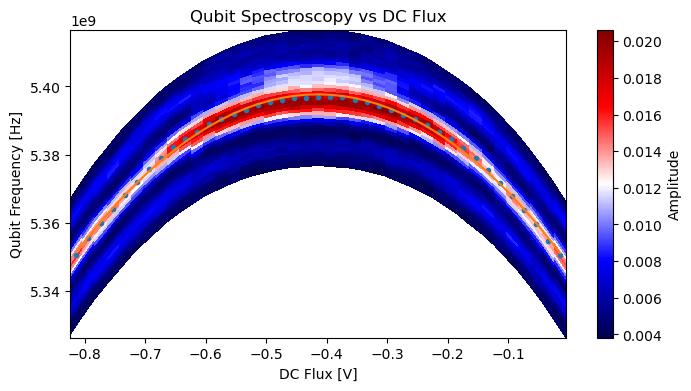

sweet spot flux: -0.41456 V


In [99]:
# udpate the sweet spot
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_flux(expt_dataset, fit_order = 2, to_plot = True, data_process_method = 'Amplitude')
machine.dc_flux[dc_flux_index].max_frequency_point = Analysis.get_sweept_spot(poly_param) + 0E1
print(f"sweet spot flux: {machine.dc_flux[dc_flux_index].max_frequency_point:.5f} V")

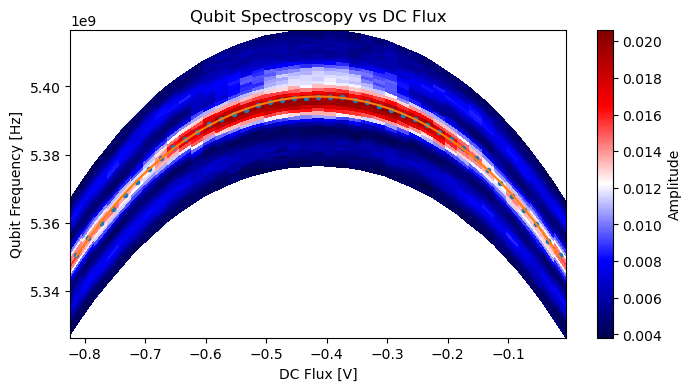

In [100]:
# save the sweep spot flux according to fitted parameter
poly_param = Analysis.exp2D.qubit_vs_flux(expt_dataset, fit_order = 4, to_plot = True, data_process_method = 'Amplitude')
machine.qubits[qubit_index].DC_tuning_curve = poly_param
machine = Analysis.set_machine(machine)

In [101]:
# go to the sweet spot, if needed
machine.dc_flux[dc_flux_index].dc_voltage = machine.dc_flux[dc_flux_index].max_frequency_point
machine = Experiment.set_Labber.set_Labber(machine, qubit_index)
machine = Analysis.set_machine(machine)

In [102]:
# octave calibration
machine = Experiment.set_octave.calibration(machine, qubit_index)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q6 for (LO, IF) = (5.446 GHz, -50.000 MHz)
------------------------------------- Calibrates r6 for (LO, IF) = (6.069 GHz, -48.430 MHz)
------------------------------------- Octave calibration finished.


## 2D qubit spectroscopy vs fast flux

In [180]:
# set DC voltage to sweet spot, after possible dc flux sweep
machine.dc_flux[dc_flux_index].dc_voltage = machine.dc_flux[dc_flux_index].max_frequency_point
machine = Experiment.set_Labber.set_Labber(machine, qubit_index)
machine = Analysis.set_machine(machine)

### slow version, compiling 1D scans

In [103]:
# try the experiment
%matplotlib qt
#ff_sweep = np.arange(-0.02,-0.28-1E-4,-0.02)
ff_sweep = np.arange(0,0.2+1E-4,0.05)
qubit_if_sweep = np.arange(-60E6, 60E6 + 1, 1E6)

machine, expt_dataset = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux_slow(machine, ff_sweep,qubit_if_sweep,
          qubit_index, ff_to_dc_ratio = None, n_avg = 1E3, cd_time = 20E3)

------------------------------------- Octave calibration starts...0% (n=4/5) --> elapsed time: 19.92s
------------------------------------- Calibrates q6 for (LO, IF) = (4.749 GHz,  290.000 MHz)
2024-06-28 12:44:24,494 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-06-28 12:44:24,615 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-06-28 12:44:24,649 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-06-28 12:44:24,683 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-06-28 12:44:24,700 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-06-28 12:44:24,722 -

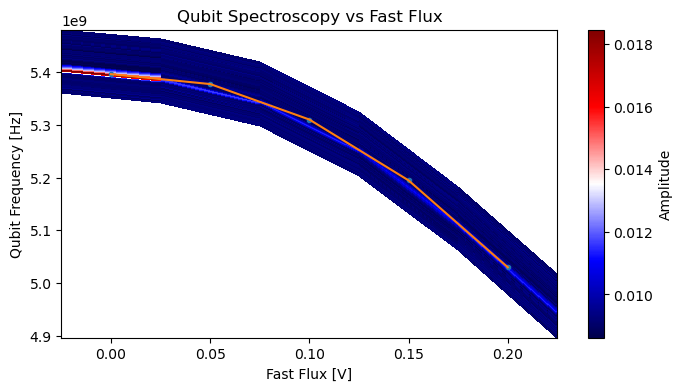

In [104]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_flux(expt_dataset, fit_order = 4, to_plot = True, data_process_method = 'Amplitude')
machine.qubits[qubit_index].AC_tuning_curve = poly_param
machine = Analysis.set_machine(machine)

### fast version, runs blockwise 2D sweeps

In [108]:
%matplotlib qt
q_freq_max = np.floor(np.polyval(machine.qubits[qubit_index].AC_tuning_curve, 0.0) * 1E6)
qubit_freq_sweep = np.arange(q_freq_max, 4.5E9, -5E6)
qubit_if_sweep = np.arange(-60E6, 60E6 + 1, 0.5E6)
machine, expt_dataset = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux(machine, qubit_freq_sweep,qubit_if_sweep,
          qubit_index, n_avg = 5E3, cd_time = 30E3, final_plot = True, live_plot = True, data_process_method = 'Phase')

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q6 for (LO, IF) = (5.098 GHz,  200.000 MHz)
2024-06-28 12:47:17,780 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-06-28 12:47:17,902 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-06-28 12:47:17,934 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-06-28 12:47:17,967 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-06-28 12:47:17,985 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-06-28 12:47:18,007 - qm - ERROR    - Runtime errors wer

In [113]:
%matplotlib qt
data = xr.load_dataset(r"Z:\QM_Data_DF5\2024\06\Data_0628\2024-06-28_q6_qubit_spec_vs_fast_flux_3.nc")
data['Phase'].plot(x = list(expt_dataset.coords.keys())[0], y = list(expt_dataset.coords.keys())[1], cmap = "seismic")

In [109]:
# save the fitted tuning curve
# %matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_flux(expt_dataset, fit_order = 4, to_plot = True, data_process_method = 'Phase')
machine.qubits[qubit_index].AC_tuning_curve = poly_param
machine = Analysis.set_machine(machine)

Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!


# TLS experiments

## TLS SWAP spectroscopy

In [114]:
# Go back to the sweet spot and calibrate
machine.qubits[qubit_index].f_01 = int(np.floor(np.polyval(machine.qubits[qubit_index].AC_tuning_curve, 0.0) * 1E6)) + 0E6
machine.octaves[0].LO_sources[1].LO_frequency = machine.qubits[qubit_index].f_01 + 50e6
machine = Analysis.set_machine(machine)

In [115]:
# octave calibration
machine = Experiment.set_octave.calibration(machine, qubit_index)

------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q6 for (LO, IF) = (5.447 GHz, -50.000 MHz)
------------------------------------- Calibrates r6 for (LO, IF) = (6.069 GHz, -48.430 MHz)
------------------------------------- Octave calibration finished.


### coarse, no baking

In [117]:
%matplotlib qt
tau_sweep_abs = np.arange(16,100 + 0.1,1)
# ff_sweep_abs = np.arange(0.09,0.13,0.002)
ff_sweep_abs = np.arange(0.1,0.45,0.001)
machine, expt_dataset = Experiment.exp2D.SWAP.swap_coarse(machine, tau_sweep_abs, ff_sweep_abs, qubit_index, 
                      n_avg = 10E3, cd_time = 30E3, live_plot=True)

KeyboardInterrupt: 

Execution stopped by user!


### fine, with baking

In [81]:
%matplotlib qt
tau_sweep_abs = np.arange(4,160,1)
# ff_sweep_abs = np.arange(0.1,0.45+1E-4,0.002)
ff_sweep_abs = np.arange(0.11,0.135,0.0005)
machine, expt_dataset = Experiment.exp2D.SWAP.swap(machine, tau_sweep_abs, ff_sweep_abs, qubit_index,
                      n_avg = 4E3, cd_time = 20E3, live_plot=True)

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 1324.15s
----------saved to Z:\QM_Data_DF5\2024\05\Data_0523\2024-05-23_q5_swap2D_3


In [41]:
%matplotlib qt
expt_dataset['I'].plot(x = list(expt_dataset.coords.keys())[0], y = list(expt_dataset.coords.keys())[1], cmap = "seismic")

In [42]:
fft_dataset = Analysis.exp2D.SWAP_fft(expt_dataset, to_plot = True)

### Add TLS iswap params

In [43]:
expt_dataset = xr.load_dataset(r"Z:\QM_Data_DF5\2024\05\Data_0522\2024-05-22_q4_swap2D_4.nc")

SWAP plot, to find the SWAP param range for different TLS

In [44]:
%matplotlib qt
expt_dataset['I'].plot(x = list(expt_dataset.coords.keys())[0], y = list(expt_dataset.coords.keys())[1], cmap = "seismic")
plt.show()

initialize the iswap params in quam

In [82]:
machine.flux_lines[qubit_index].iswap.length =[]
machine.flux_lines[qubit_index].iswap.level = []

#### TLS0

In [83]:
flux_min, flux_max = (0.115,0.135)
interaction_time_min, interaction_time_max = (4,20)
flux_range = (flux_min, flux_max)
interaction_time_range = (interaction_time_min, interaction_time_max)

iswap flux level:  0.12550 [V]
iswap flux length:  14 [ns]


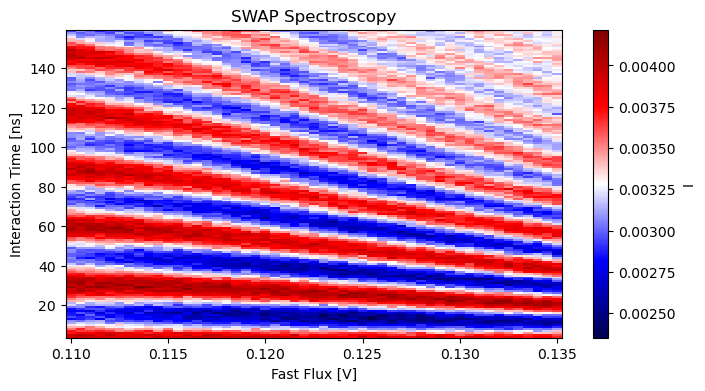

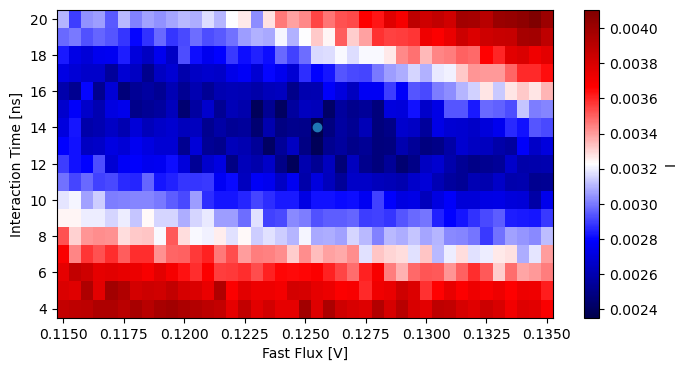

Execution stopped by user!


In [84]:
%matplotlib inline
iswap_flux, iswap_time = Analysis.exp2D.SWAP_find_iswap(expt_dataset, flux_range, interaction_time_range, to_plot = True)

In [85]:
machine.flux_lines[qubit_index].iswap.length.append(iswap_time)
machine.flux_lines[qubit_index].iswap.level.append(iswap_flux)
machine = Analysis.set_machine(machine)

#### TLS1

In [ ]:
flux_min, flux_max = (0.32,0.335)
interaction_time_min, interaction_time_max = (10,28)
flux_range = (flux_min, flux_max)
interaction_time_range = (interaction_time_min, interaction_time_max)

In [ ]:
%matplotlib inline
iswap_flux, iswap_time = Analysis.exp2D.SWAP_find_iswap(expt_dataset, flux_range, interaction_time_range, to_plot = True)

In [ ]:
machine.flux_lines[qubit_index].iswap.length.append(iswap_time)
machine.flux_lines[qubit_index].iswap.level.append(iswap_flux)
machine = Analysis.set_machine(machine)

#### TLS2

In [ ]:
flux_min, flux_max = (0.375,0.385)
interaction_time_min, interaction_time_max = (18,30)
flux_range = (flux_min, flux_max)
interaction_time_range = (interaction_time_min, interaction_time_max)

In [ ]:
%matplotlib inline
iswap_flux, iswap_time = Analysis.exp2D.SWAP_find_iswap(expt_dataset, flux_range, interaction_time_range, to_plot = True)

In [ ]:
machine.flux_lines[qubit_index].iswap.length.append(iswap_time)
machine.flux_lines[qubit_index].iswap.level.append(iswap_flux)
machine = Analysis.set_machine(machine)

### estiguess of the TLS frequency, based on iswap flux level

In [ ]:
freq_tls = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[qubit_index].iswap.level)
machine.qubits[qubit_index].f_tls = (np.floor(freq_tls*1E6)).tolist()    
machine = Analysis.set_machine(machine)

initialize pi_length_tls, pi_amp_tls

In [ ]:
machine.qubits[qubit_index].pi_length_tls = [200] * len(machine.flux_lines[qubit_index].iswap.length)
machine.qubits[qubit_index].pi_amp_tls = [0.45] * len(machine.flux_lines[qubit_index].iswap.length)
machine = Analysis.set_machine(machine)